# Projeto da disciplina de Introdução à Ciência de Dados

Estudante: Fernando de Barros (fbwn@cin.ufpe.br)

## 1. Carregamento das Bibliotecas e do Dataset

In [1]:
import math
import sys  
import datetime
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
from scipy import stats

# Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors, OSM, CARTODBPOSITRON, WIKIMEDIA

pd.set_option('display.max_columns', None)

## Inicialização de variaveis para o Bokeh
output_notebook()
tile_provider = OSM
colors=['red','blue', 'black', 'yellow']


Loading BokehJS ...

## Dublin Bus GPS sample data from Dublin City Council (Insight Project)

Bus GPS Data Dublin Bus GPS data across Dublin City, from Dublin **City Council'traffic control**, in csv format. 

Each datapoint (row in the CSV file) has the following entries:

- Timestamp micro since 1970 01 01 00:00:00 GMT  
- Line ID  
- Direction  
- Journey Pattern ID  
- Time Frame (The start date of the production time table - in Dublin the production time table starts at 6am and ends at 3am)  
- Vehicle Journey ID (A given run on the journey pattern)  
- Operator (Bus operator, not the driver)  
- Congestion [0=no,1=yes]  
- Lon WGS84  
- Lat WGS84
- Delay (seconds, negative if bus is ahead of schedule)  
- Block ID (a section ID of the journey pattern)  
- Vehicle ID  
- Stop ID  
- At Stop [0=no,1=yes]

Fonte: https://data.gov.ie/dataset/dublin-bus-gps-sample-data-from-dublin-city-council-insight-project


### Abre arquivo referente aos dias 10~12 de Janeiro de 2013

### Colunas originais do dataset

In [2]:
features = ['timestamp','line_id','direction','journey_id',
            'time_frame','vehicle_journey_id','operator',
            'congestion','lng','lat','delay','block_id',
            'vehicle_id','stop_id', 'stop']

In [3]:
df = pd.read_csv(
    '../data/siri.20130110.csv.gz', 
    compression='gzip', 
    names=features, 
    header=None)
for i in tqdm(range(20130111,20130112,1)):
    data = pd.read_csv(
        '../data/siri.'+str(i)+'.csv.gz', 
        compression='gzip', 
        names=features, 
        header=None)
    df = pd.concat([df,data])

100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


### Lista com nomes das colunas que formam a chave da trajetória

In [4]:
trajetoria = [
    'line_id', 'journey_id', 'time_frame',
    'vehicle_journey_id', 'operator', 'vehicle_id'
             ]

## Análise inicial do dataset

In [5]:
df.head()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop
0,1357776002000000,31.0,0,NaN,2013-01-09,5509,CF,0,-6.257756,53.349159,0,31008,38075,296.0,0
1,1357776002000000,66.0,0,066A0001,2013-01-09,2390,PO,0,-6.406750,53.357983,-101,66001,33376,3993.0,0
2,1357776002000000,49.0,0,00491001,2013-01-09,2837,RD,0,-6.272375,53.341053,-149,49006,33483,2383.0,0
3,1357776002000000,14.0,0,00141001,2013-01-09,5452,SL,0,-6.251083,53.357666,-251,14101,33113,248.0,1
4,1357776002000000,40.0,0,040D0001,2013-01-09,2217,HN,0,-6.390792,53.422108,-478,40203,38071,7104.0,0


In [6]:
df.tail()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop
1729769,1357948798000000,83.0,0,00830001,2013-01-11,5776,HN,0,-6.302700,53.318638,-144,83011,40020,2489.0,0
1729770,1357948798000000,39.0,0,NaN,2013-01-11,3175,PO,0,-6.244823,53.328770,170,39020,36054,767.0,0
1729771,1357948798000000,15.0,0,00151001,2013-01-11,5112,HN,0,-6.152171,53.402569,503,15105,33502,7245.0,1
1729772,1357948798000000,272.0,0,027B0002,2013-01-11,369,HN,0,-6.276100,53.418041,129,272005,33504,1629.0,0
1729773,1357948798000000,39.0,0,00391001,2013-01-11,3020,PO,0,-6.252700,53.331966,-486,39010,36061,7339.0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3430406 entries, 0 to 1729773
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamp           int64  
 1   line_id             float64
 2   direction           int64  
 3   journey_id          object 
 4   time_frame          object 
 5   vehicle_journey_id  int64  
 6   operator            object 
 7   congestion          int64  
 8   lng                 float64
 9   lat                 float64
 10  delay               int64  
 11  block_id            int64  
 12  vehicle_id          int64  
 13  stop_id             float64
 14  stop                int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 418.8+ MB


In [8]:
df.describe()

,timestamp,line_id,direction,vehicle_journey_id,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop
count,3.430406e+06,3.429963e+06,3430406.0,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.236571e+06,3.430406e+06
mean,1.357871e+15,7.674974e+01,0.0,8.030546e+03,1.081942e-02,-6.271851e+00,5.334449e+01,-1.286452e+01,1.157287e+05,3.534091e+04,2.755840e+03,2.306231e-01
std,4.666748e+10,1.110898e+02,0.0,6.354814e+04,1.034522e-01,8.350831e-02,5.512406e-02,4.634146e+02,2.029284e+05,3.250063e+03,2.187218e+03,4.212317e-01
min,1.357776e+15,1.000000e+00,0.0,1.000000e+00,0.000000e+00,-6.615016e+00,5.307028e+01,-7.334000e+03,1.001000e+03,2.804700e+04,2.000000e+00,0.000000e+00
25%,1.357828e+15,2.500000e+01,0.0,2.007000e+03,0.000000e+00,-6.307797e+00,5.331963e+01,-1.880000e+02,1.602100e+04,3.329100e+04,8.330000e+02,0.000000e+00
50%,1.357885e+15,4.000000e+01,0.0,3.856000e+03,0.000000e+00,-6.261396e+00,5.334624e+01,0.000000e+00,4.021000e+04,3.351400e+04,2.101000e+03,0.000000e+00
75%,1.357914e+15,8.300000e+01,0.0,5.520000e+03,0.000000e+00,-6.232217e+00,5.337394e+01,1.290000e+02,1.020050e+05,3.801000e+04,4.411000e+03,0.000000e+00
max,1.357949e+15,7.470000e+02,0.0,9.997110e+05,1.000000e+00,-6.052917e+00,5.360655e+01,1.161220e+05,8.350020e+05,4.307800e+04,7.552000e+03,1.000000e+00


Retirar a coluna DIRECTION que não apresenta qualquer informação

In [9]:
df.drop('direction', axis=1, inplace=True)
'direction' in df.columns

False

### Ajusta tipo das features

#### Boolean

In [10]:
df.stop = df.stop.astype('bool')
df.congestion = df.congestion.astype('bool')

#### Datetime (microseconds - us)

In [11]:
df['datetime'] = pd.to_datetime(df["timestamp"], unit='us')

##### Criação de duas novas features derivadas (day, hour)

In [12]:
df['hour'] = df["datetime"].dt.hour
df['day'] = df["datetime"].dt.day

### Categoricos

Indicar quais das colunas são categoricas:

In [13]:
list_cats = ['line_id', 'journey_id' , 'time_frame', 
             'vehicle_journey_id', 'operator', 'block_id', 
             'vehicle_id', 'stop_id']

In [14]:
for cat in list_cats:
    df[cat] = df[cat].astype('category')

### Quantos valores distintos há em cada features que compõe a chave?

In [15]:
lista_tamanhos = map((lambda x: len(df[x].unique())), trajetoria)
mescla = zip(trajetoria, lista_tamanhos)
print('Descritivo de instâncias únicas para cada atributo da chave:')
tuple(mescla)

Descritivo de instâncias únicas para cada atributo da chave:


(('line_id', 66),
 ('journey_id', 441),
 ('time_frame', 3),
 ('vehicle_journey_id', 7495),
 ('operator', 8),
 ('vehicle_id', 850))

### Como o 'prodution time' é entre 6am e 3am. Existem rotas fora desta janelas?

In [16]:
df[(3 < df.hour) & (df.hour < 6)]

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,datetime,hour,day


## Análisar trajetórias

### ( ! ) Os blocos abaixo foram retirados pois estava dando erro com a alocação de memória na função groupby.

Eles vão fazem a análise do número de pontos em cada trajetórias e servem de embasamento para a seleção do número mínimo de 50 pontos para validar uma trajetória.

Observamos uma partição dos número de pontos por trajetória um pouco abaixo de 100 pontos. Mais a frente iremos usar o valor limite de 50 pontos para excluir as trajetórias abaixo deste limiar.

In [17]:
minimo_pontos = 50

## Gerar trajetórias

Na função que gera trajetórias incluimos algumas features aproveitando o fato de que esta geração de trajetórias percorre o dataset linha a linha, uma vez que precisamos identificar um valor limite entre duas amostras do GPS para poder validar a trajetória. Usamos aqui o valor é de 5 minutos.

In [18]:
gps = ['lat','lng']

def delta_time(t1, t2) -> float:
    '''
    Retorna diferença temporal em segundos
    Ou np.nan se a diferença temporal para o ponto anterior
    for superior a 5 minutos
    '''
    t1 = pd.to_datetime(t1,unit='us')
    t2 = pd.to_datetime(t2,unit='us')
    time = pd.Timedelta(np.abs(t2 - t1))
    if (time.seconds > 5*60):
        return np.nan
    else:        
        return time.seconds

def calc_deltas(frame):
    '''
    Retorna o DF com as colunas de delta[tempo, distancia] preenchidas
    Depende do valor da linha anterior (temporalmente)
    Nas funções MAP são enviados os valores da linha presente e da anterior (shift(1))
    '''
    frame.dist_from_old_point = 0
    frame.time_from_old_point = 0
    delta_d = list(map(
        lambda x, y: geodesic(x,y).meters, frame[gps].values[1:], frame[gps].shift(1).values[1:]))
    delta_t = list(map(
        lambda x, y: delta_time(x,y), frame['timestamp'].values[1:], frame['timestamp'].shift(1).values[1:]))
    if (len(frame[frame.isna()]) == 0):
        print('Não há quaisquer valores NaN')
    frame['dist_from_old_point'] = [0, *delta_d]
    frame['time_from_old_point'] = [0, *delta_t]
    return frame

Repartição do dataset em uma lista contendo vários dataframes, cada um referente a uma trajaetória 

No GroupBy a seguir todas as instâncias com uma das features listadas como chave com valor NaN são descartadas.

In [19]:
# Salvar as descartadas para plotagem ao final do notebook
dfs_menos_q_50 = [x for _,x in df.groupby(trajetoria) if ((len(x) < 50) & (len(x) > 10))]

# Repartição
dfs = [x for _,x in df.groupby(trajetoria) if (len(x) > 50)]

# Seleciona 100 trajetórias aleatórias
random_traj = random.sample(range(0, len(dfs)), 100)
dfs = [dfs[i] for i in random_traj] 

# Chamas calc_deltas para cada trajetória
dfs = list(map(calc_deltas,dfs))

# concatena as trajetorias de volta em um DF unico
dfs = pd.concat(dfs)

### Criação de novas features

#### Velocidade e Aceleração

In [20]:
dfs['velocity'] = dfs.dist_from_old_point / dfs.time_from_old_point
dfs['acc'] = dfs.velocity * (1/dfs.time_from_old_point)
dfs['acc'].fillna(value=0, inplace=True)
dfs['velocity'].fillna(value=0, inplace=True)

#### ID única para cada trajetória

In [21]:
dfs[trajetoria] = dfs[trajetoria].astype('string')
dfs['ID'] = dfs[trajetoria].agg('-'.join, axis=1).astype('category').cat.codes

### Exclusão de pontos que diferem mais que 5 minutos do prévio

Verifica também se os pontos restantes (anteriores) tem uma a quantidade mínima de pontos para validar a trajetória

In [22]:
# IDs com np.nan na coluna time_from_old_point
lista_IDs = dfs[dfs.time_from_old_point.isna()].ID.unique()
print('Pontos a serem analisados:')
print(lista_IDs)
def index2remove(ID):
    cc = dfs[dfs.ID==ID]
    if (len(cc) == 0):
        return
    cc.sort_values('timestamp')
    ts = cc[cc['time_from_old_point'].isna()].timestamp.values[0]
    if (len(cc[cc.timestamp <= ts]) < 50):
        #exclui todo mundo no caso de não ter 50 pontos restantes
        print( f'A trajetória {ID} não tem o mínimos de pontos')
        dfs.drop(cc.index, inplace=True)
        return cc.index
    else:
        # exclui só do ponto problemático em diante
        dfs.drop(cc[cc.timestamp >= ts].index, inplace=True)
        return cc[cc.timestamp >= ts].index
remover = list(map(index2remove,lista_IDs))

Pontos a serem analisados:
[53 76 80]


In [23]:
lista_IDs = dfs[dfs.time_from_old_point.isna()].ID.values
lista_IDs

array([], dtype=int8)

In [24]:
dfs.head()

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,datetime,hour,day,dist_from_old_point,time_from_old_point,velocity,acc,ID
1001236,1357918949000000,79.0,00790001,2013-01-11,2921,CD,False,-6.2604,53.346485,0,79007,33188,326.0,True,2013-01-11 15:42:29,15,11,0.0,0.0,0.0,0.0,89
1001835,1357918967000000,79.0,00790001,2013-01-11,2921,CD,False,-6.2604,53.346485,0,79007,33188,326.0,True,2013-01-11 15:42:47,15,11,0.0,18.0,0.0,0.0,89
1002411,1357918988000000,79.0,00790001,2013-01-11,2921,CD,False,-6.2604,53.346485,0,79007,33188,326.0,True,2013-01-11 15:43:08,15,11,0.0,21.0,0.0,0.0,89
1002915,1357919006000000,79.0,00790001,2013-01-11,2921,CD,False,-6.2604,53.346485,0,79007,33188,326.0,True,2013-01-11 15:43:26,15,11,0.0,18.0,0.0,0.0,89
1003586,1357919027000000,79.0,00790001,2013-01-11,2921,CD,False,-6.2604,53.346485,0,79007,33188,326.0,True,2013-01-11 15:43:47,15,11,0.0,21.0,0.0,0.0,89


In [25]:
#backup
df = dfs.copy()

In [26]:
df.tail()

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,datetime,hour,day,dist_from_old_point,time_from_old_point,velocity,acc,ID
1711808,1357947232000000,40.0,00401001,2013-01-11,5656,HN,False,-6.265316,53.415066,60,40109,38068,7474.0,True,2013-01-11 23:33:52,23,11,0.000000,18.0,0.000000,0.000000,64
1711827,1357947234000000,40.0,00401001,2013-01-11,5656,HN,False,-6.266016,53.417000,60,40109,38068,7474.0,True,2013-01-11 23:33:54,23,11,220.217403,2.0,110.108701,55.054351,64
1712072,1357947253000000,40.0,00401001,2013-01-11,5656,HN,False,-6.267300,53.417217,60,40109,38068,7474.0,True,2013-01-11 23:34:13,23,11,88.721426,19.0,4.669549,0.245766,64
1712336,1357947275000000,40.0,00401001,2013-01-11,5656,HN,False,-6.271833,53.417850,60,40109,38068,7474.0,True,2013-01-11 23:34:35,23,11,309.513178,22.0,14.068781,0.639490,64
1712584,1357947294000000,40.0,00401001,2013-01-11,5656,HN,False,-6.277184,53.418152,60,40109,38068,7474.0,True,2013-01-11 23:34:54,23,11,357.356196,19.0,18.808221,0.989906,64


Abaixo percebemos valores que não podem pertencer a velocidades reais.

In [27]:
print( f'Por exemplo o valor máximo de {df.velocity.max()} m/s para velocidade ou {df.acc.max()} m/s² para aceleração')

Por exemplo o valor máximo de 421.3058483027955 m/s para velocidade ou 91.72057333019845 m/s² para aceleração


In [28]:
new_cols = ['velocity', 'acc', 'time_from_old_point', 'dist_from_old_point',]
            #'MF_velocity', 'MF_acc', 'MF_dist_from_old_point']
df[new_cols].describe()

,velocity,acc,time_from_old_point,dist_from_old_point
count,18763.000000,18763.000000,18763.000000,18763.000000
mean,5.322750,0.332340,20.436444,105.192489
std,8.713750,1.899134,7.974051,143.482590
min,0.000000,0.000000,0.000000,0.000000
25%,0.346102,0.018103,19.000000,6.141979
50%,3.913140,0.187870,20.000000,79.382766
75%,8.056425,0.398924,21.000000,164.176662
max,421.305848,91.720573,280.000000,7677.307819


<AxesSubplot:>

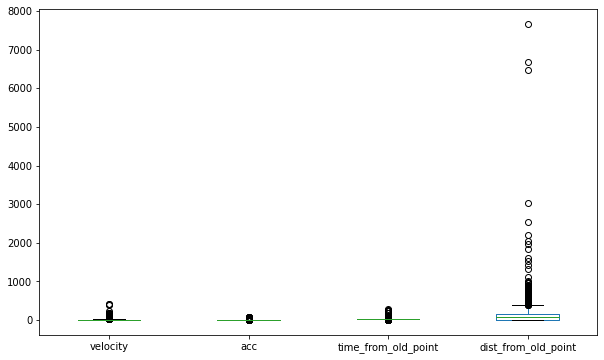

In [29]:
df[new_cols].plot(kind='box', figsize=(10,6))

## Teste de métodos para detecção de outliers

### Isolation Forest sobre a velocidade e a aceleração

In [30]:
from sklearn.ensemble import IsolationForest

In [31]:
feats = ['velocity','acc']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats])
scores = clf.predict(df[feats])
df['outlier'] = scores

### Isolation Forest com normalização dos valores de velocidade e aceleração

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['velocity','acc']]), columns = ['velocity','acc'])
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df_normalized)
scores = clf.predict(df_normalized)
df['outlier_norm'] = scores

In [34]:
df[df.outlier == 1][feats].describe()

,velocity,acc
count,15291.000000,15291.000000
mean,3.320523,0.163254
std,3.099348,0.154165
min,0.000000,0.000000
25%,0.056143,0.002814
50%,2.780425,0.133614
75%,5.769963,0.283542
max,10.566352,0.528445


In [35]:
df[df.outlier_norm== 1][feats].describe()

,velocity,acc
count,15304.000000,15304.000000
mean,3.326514,0.163529
std,3.104265,0.154404
min,0.000000,0.000000
25%,0.056534,0.002827
50%,2.783468,0.133882
75%,5.777791,0.283965
max,10.566352,0.528445


array([[<AxesSubplot:title={'center':'velocity'}>,
        <AxesSubplot:title={'center':'acc'}>]], dtype=object)

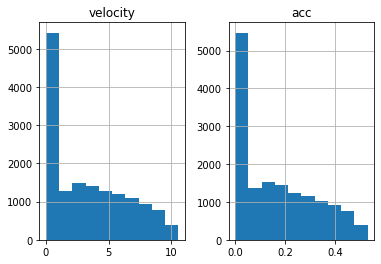

In [36]:
df[df.outlier == 1][feats].hist()

Ambos os método retornam valores plausiveis de velocidade e aceleração

Entretanto, velocidade e aceleração foram valores criados apartir das distâncias entre pontos. 

### Poderiamos aplicar a detecção de outliers nestas features geradoras ou o cálculo de velocidade e aceleração nos ajudou a discriminar melhor os outliers?

### Isolation Forest a partir das colunas distância e tempo desde o ponto anterior

In [37]:
feats_0 = ['dist_from_old_point','time_from_old_point']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats_0])
scores = clf.predict(df[feats_0])
df['outlier_0'] = scores

In [38]:
df[df.outlier_0== 1][feats_0].describe()

,dist_from_old_point,time_from_old_point
count,15510.000000,15510.000000
mean,86.121657,19.892134
std,76.974263,1.460167
min,0.000000,14.000000
25%,8.133039,19.000000
50%,72.317086,20.000000
75%,142.995206,21.000000
max,280.886566,24.000000


Como os valores não são plausíveis. Concluímos que a geração das novas features: velocidade e aceleração foram significativas para a detecção destes pontos anomalos.

### Verificar se o método Local Outlier Factor oferece também uma resposta plausível

In [39]:
from sklearn.neighbors import LocalOutlierFactor

In [40]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[feats])
df['outlier2'] = scores

In [41]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['velocity','acc']]), columns = ['velocity','acc'])
rng = np.random.RandomState(42)
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df_normalized)
df['outlier2_norm'] = scores

In [42]:
df[df.outlier2 == 1][feats].describe()

,velocity,acc
count,16886.000000,16886.000000
mean,5.110923,0.276102
std,6.034755,0.657223
min,0.000000,0.000000
25%,0.196659,0.009943
50%,3.842396,0.184570
75%,7.985244,0.397439
max,118.114638,26.453240


In [43]:
df[df.outlier2_norm == 1][feats].describe()

,velocity,acc
count,16886.000000,16886.000000
mean,5.129696,0.287283
std,6.051702,1.004158
min,0.000000,0.000000
25%,0.196108,0.010870
50%,3.928575,0.188209
75%,8.020091,0.395672
max,225.392643,79.385183


Os valores de máximos ainda apresentam pontos que não se adequam à realidade.

## Testar detecção de outliers MEAN FILTER

In [44]:
df['MF_lat'] = df['lat'].rolling(5, min_periods=1).mean()
df['MF_lng'] = df['lng'].rolling(5, min_periods=1).mean()

In [45]:
gps = ['MF_lat','MF_lng']

def delta_time(t1, t2) -> float:
    '''
    Retorna diferença temporal em segundos
    Ou np.nan se a diferença temporal para o ponto anterior
    for superior a 5 minutos
    '''
    t1 = pd.to_datetime(t1,unit='us')
    t2 = pd.to_datetime(t2,unit='us')
    time = pd.Timedelta(np.abs(t2 - t1))
    if (time.seconds > 5*60):
        return np.nan
    else:        
        return time.seconds

def MF_calc_deltas(frame):
    '''
    Retorna o DF com as colunas de delta[tempo, distancia] preenchidas
    Depende do valor da linha anterior (temporalmente)
    Nas funções MAP são enviados os valores da linha presente e da anterior (shift(1))
    '''
    #frame.dist_from_old_point = 0
    frame.time_from_old_point = 0
    delta_d = list(map(
        lambda x, y: geodesic(x,y).meters, frame[gps].values[1:], frame[gps].shift(1).values[1:]))
    delta_t = list(map(
        lambda x, y: delta_time(x,y), frame['timestamp'].values[1:], frame['timestamp'].shift(1).values[1:]))
    if (len(frame[frame.isna()]) == 0):
        print('Não há quaisquer valores NaN')
    frame['MF_dist_from_old_point'] = [0, *delta_d]
    frame['time_from_old_point'] = [0, *delta_t]
    return frame

In [46]:
# Repartição
dfs = [x for _,x in df.groupby(trajetoria) if (len(x) > 50)]
# Chamas calc_deltas para cada trajetória
dfs = list(map(MF_calc_deltas,dfs))
# concatena as trajetorias de volta em um DF unico
df = pd.concat(dfs)

In [47]:
df['MF_vel'] = df['MF_dist_from_old_point'] / df['time_from_old_point']
df['MF_acc'] = df['MF_dist_from_old_point'] / (df['time_from_old_point'] * df['time_from_old_point'])

#df[df.MF_vel == np.inf].time_from_old_point.unique()
df['MF_vel'].fillna(value=0, inplace=True)
df['MF_acc'].fillna(value=0, inplace=True)

<AxesSubplot:>

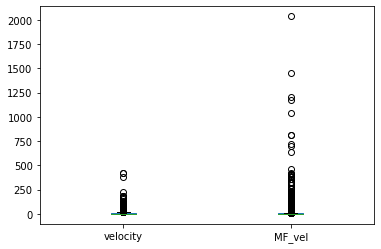

In [48]:
df[['velocity', 'MF_vel']].plot(kind='box')

In [49]:
feats = ['velocity','acc']
feats_MF = ['MF_vel', 'MF_acc']

In [50]:
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats_MF])
scores = clf.predict(df[feats_MF])
df['outlier_MF'] = scores

<AxesSubplot:>

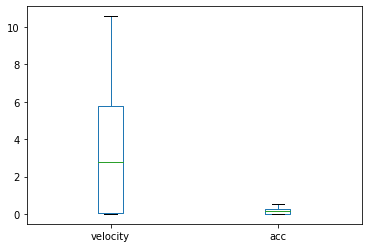

In [51]:
df[df.outlier== 1][feats].plot(kind='box')

<AxesSubplot:>

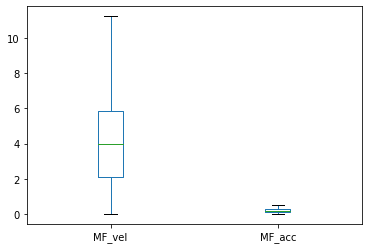

In [52]:
df[df.outlier_MF== 1][feats_MF].plot(kind='box')

In [53]:
df.MF_vel.describe()

count    18763.000000
mean         7.760204
std         32.851732
min          0.000000
25%          2.377622
50%          4.398179
75%          6.851468
max       2037.184104
Name: MF_vel, dtype: float64

In [54]:
df[df.outlier_MF== 1].MF_vel.describe()

count    16586.000000
mean         4.027848
std          2.574272
min          0.000000
25%          2.107763
50%          3.975104
75%          5.857992
max         11.234377
Name: MF_vel, dtype: float64

In [55]:
print (f'O uso do Mean Filter sozinho não conseguiu retirar os pontos anômalos do dataset.')
print (f'Apenas após utilização do Mean Filter conjuntamente à detecção com auxílio da técnica Random Forest obtivemos um valor máximo de velocidade plausível.')


O uso do Mean Filter sozinho não conseguiu retirar os pontos anômalos do dataset.
Apenas após utilização do Mean Filter conjuntamente à detecção com auxílio da técnica Random Forest obtivemos um valor máximo de velocidade plausível.


### Assim iremos excluir quem foi detectado como outlier pelo Random Forest 

### Escolhemos o resultado sem a normalização 

### Rando Foreste pós normalização e pós Mean Filter também seriam alternativas válidas. Por simplicidade preferimos selecionamos o primeiro método (menos passos).

In [56]:
df1 = df[df.outlier==1]

In [57]:
df.dist_from_old_point.unique()

array([0.        , 1.98077615, 3.78394051, ..., 1.66940787, 1.13065551,
       1.13065512])

In [58]:
df1.drop(['outlier', 'outlier_0', 'outlier2','outlier_norm','outlier2_norm','day','stop_id','block_id', 'delay'],axis=1,inplace=True)

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
df1.describe()

,timestamp,lng,lat,hour,dist_from_old_point,time_from_old_point,velocity,acc,ID,MF_lat,MF_lng,MF_dist_from_old_point,MF_vel,MF_acc,outlier_MF
count,1.529100e+04,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000,15291.000000
mean,1.357876e+15,-6.266007,53.345461,14.487019,68.965680,20.423059,3.320523,0.163254,51.371330,53.345480,-6.265960,129.283596,6.680521,0.445056,0.876921
std,4.599294e+10,0.079775,0.053129,4.757248,65.836934,5.841342,3.099348,0.154165,28.595594,0.052669,0.079102,392.260371,26.346399,6.150859,0.480650
min,1.357798e+15,-6.591024,53.070717,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.070717,-6.590381,0.000000,0.000000,0.000000,-1.000000
25%,1.357835e+15,-6.300161,53.321640,10.000000,1.130981,19.000000,0.056143,0.002814,28.000000,53.321686,-6.300425,41.389427,1.991785,0.091930,1.000000
50%,1.357894e+15,-6.260881,53.345905,15.000000,56.360467,20.000000,2.780425,0.133614,52.000000,53.345863,-6.260884,79.073225,3.859698,0.190099,1.000000
75%,1.357916e+15,-6.232183,53.367821,18.000000,118.928524,21.000000,5.769963,0.283542,76.000000,53.367772,-6.232832,117.154577,5.816565,0.291807,1.000000
max,1.357947e+15,-6.053067,53.606518,23.000000,335.123512,251.000000,10.566352,0.528445,99.000000,53.606257,-6.053993,8303.194330,1448.161931,589.506931,1.000000


<AxesSubplot:>

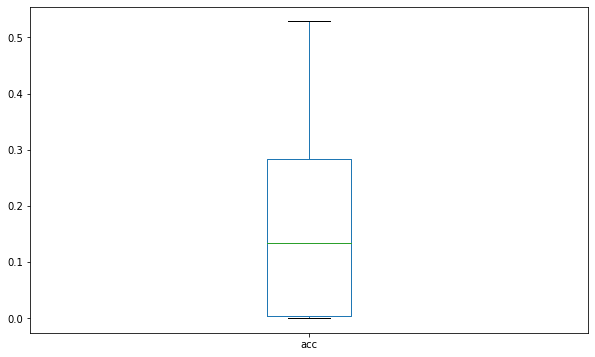

In [60]:
df1['acc'].plot(kind='box', figsize=(10,6))

<AxesSubplot:>

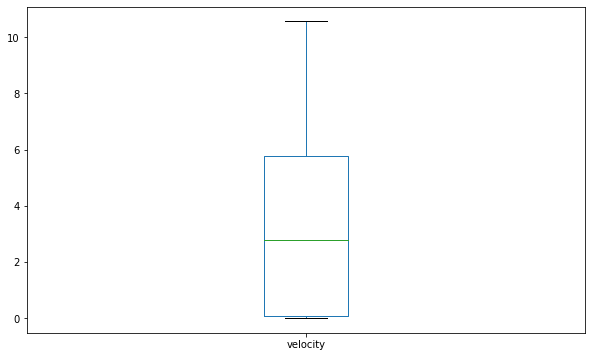

In [61]:
df1['velocity'].plot(kind='box', figsize=(10,6))

<AxesSubplot:>

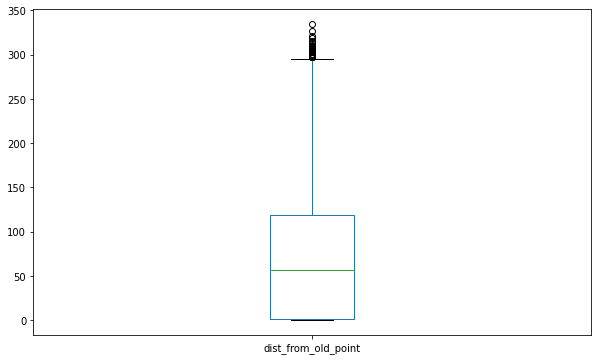

In [62]:
df1['dist_from_old_point'].plot(kind='box', figsize=(10,6))

## Teste de hipótese

### Verificação da distribuição da velocidade

<AxesSubplot:xlabel='velocity', ylabel='Count'>

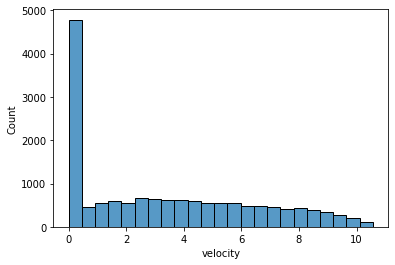

In [63]:
sns.histplot(x=df1.velocity)

Anderson-Darling test for data coming from a particular distribution.

The Anderson-Darling test tests the null hypothesis that a sample is
drawn from a population that follows a particular distribution.
For the Anderson-Darling test, the critical values depend on
which distribution is being tested against.  This function works
for normal, exponential, logistic, or Gumbel (Extreme Value
Type I) distributions.

If the returned statistic is larger than these critical values then
for the corresponding significance level, the null hypothesis that
the data come from the chosen distribution can be rejected.

In [64]:
result_test = stats.anderson(df1.velocity, dist='norm')

In [65]:
print(f'Statistic: {result_test[0]}')

print(f'Critical Value: {result_test[1]}')

print(f'Significance Level: {result_test[2]}')


Statistic: 530.4834913606828
Critical Value: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]


In [66]:
print( f'Como o valor {result_test[0]} é maior que qualquer valor crítico {result_test[1]}, então o teste é significativo.')
print('Assim podemos rejeitar a hipótese nula que os pontos vem de uma distribuição normal')

Como o valor 530.4834913606828 é maior que qualquer valor crítico [0.576 0.656 0.787 0.918 1.092], então o teste é significativo.
Assim podemos rejeitar a hipótese nula que os pontos vem de uma distribuição normal


### Distribuição do log da velocidade (valores diferentes de zero)

<AxesSubplot:xlabel='velocity', ylabel='Count'>

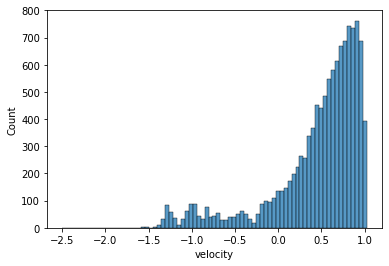

In [67]:
sns.histplot(x=df1[df1.velocity!=0].velocity.apply(np.log10))

### Teste de normalidade para log10(velocidade!=0)

In [68]:
result_test = stats.anderson(df1[df1.velocity!=0].velocity.apply(np.log10), dist='norm')


In [69]:
print(f'Statistic: {result_test[0]}')

print(f'Critical Value: {result_test[1]}')

print(f'Significance Level: {result_test[2]}')

Statistic: 656.9741450563015
Critical Value: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]


Assim não iremos admitir que haja uma distribuição simétrica na velocidade.

### Para quais horários há uma diferença entre a velocidade capturada antes e após?

### Mann-Whitney rank test

A escolha do teste se dá por ausência de normalidade na distribuição e independência entre as trajetórias

Há um caso limite em que uma mesma trajetória ocorre através de horas diferentes, o que não seria uma medição independente. Porém para cada hora o número de medições em viagens independentes (que acontecem totalmente antes/depois) é muito maior do que as medições em viagens que cruzaram aquele horário.

In [70]:
hours = df1.hour.unique()
lh_vel = [stats.mannwhitneyu(df1[df1.hour <= h].velocity, df1[df1.hour > h].velocity)[1] for h in hours]

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


<AxesSubplot:>

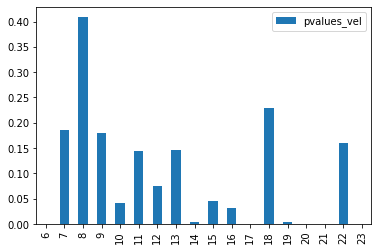

In [71]:
x = pd.DataFrame(data={'pvalues_vel':lh_vel}, index=hours).sort_index()
x.plot(kind='bar')

In [72]:
x = x.reset_index()


In [73]:
x1 = x[x.pvalues_vel<0.05]

In [74]:
x1.index = x1['index']

<AxesSubplot:xlabel='index'>

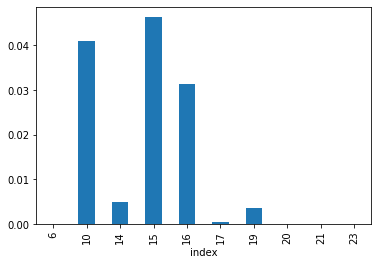

In [75]:
x1.pvalues_vel.plot(kind='bar')

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='velocity'>

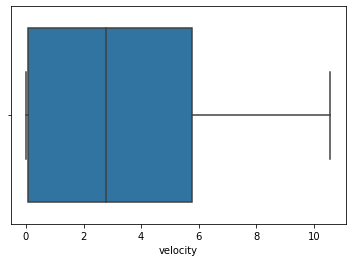

In [76]:
sns.boxplot(df1.velocity)

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


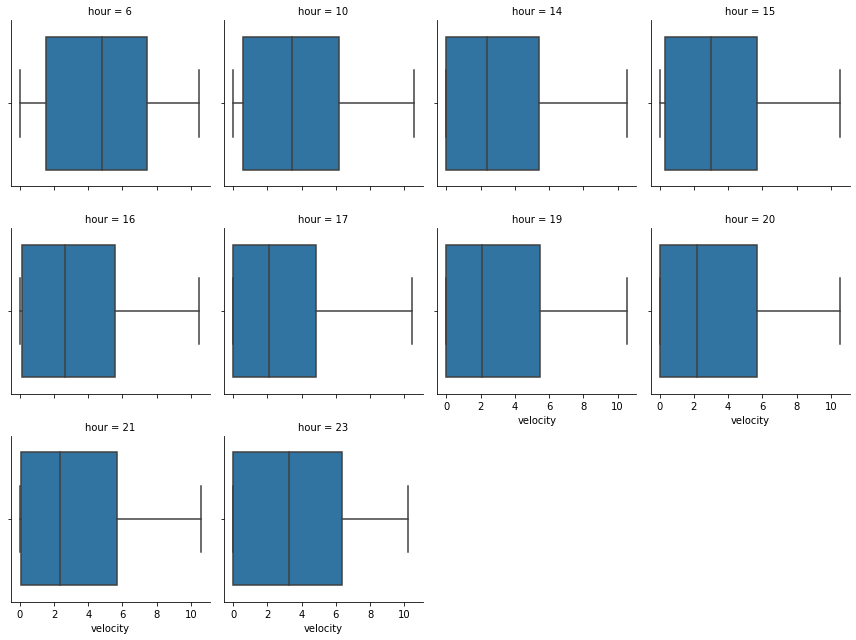

In [77]:
g = sns.FacetGrid(df1[df1.hour.isin(x1['index'].values)], col="hour", col_wrap=4)
g.map(sns.boxplot, 'velocity')


In [78]:
horas = x1['index'].values

In [79]:
print( f'Para cada uma das seguintes horas: {horas}')
print('Podemos dizer que há uma diferença entre as velocidades amostradas antes e após a mesma.')
print()
print('Por exemplo:')
print( f'Como o pvalue para as {horas[4]} horas é:\t {x1.iloc[4].pvalues_vel}:')
print( 'Podemos negar H0; Negamos que a distribuiçãos das velocidades sejam iguais.')
print( f'Podemos dizr que há uma difença entre as velocidades antes e após as {horas[4]} horas')

Para cada uma das seguintes horas: [ 6 10 14 15 16 17 19 20 21 23]
Podemos dizer que há uma diferença entre as velocidades amostradas antes e após a mesma.

Por exemplo:
Como o pvalue para as 16 horas é:	 0.03128356676236456:
Podemos negar H0; Negamos que a distribuiçãos das velocidades sejam iguais.
Podemos dizr que há uma difença entre as velocidades antes e após as 16 horas


### Quais linhas ('line_id') tem uma mediana da velocidade maior/menor que a mediana geral


#### Wilcoxon signed-rank test (one-side)

The Wilcoxon signed-rank test tests the null hypothesis that two
related paired samples come from the same distribution. In particular,
it tests whether the distribution of the differences x - y is symmetric
about zero. It is a non-parametric version of the paired T-test.


The one-sided test has the null hypothesis that the median is 
positive against the alternative that it is negative 
(``alternative == 'less'``), or vice versa (``alternative == 'greater.'``).

alternative : {"two-sided", "greater", "less"}, optional
    The alternative hypothesis to be tested, see Notes. Default is
    "two-sided".

In [80]:
lines = df1.line_id.unique()
gt_vel = [stats.wilcoxon(df1[df1.line_id == t].velocity - df1.velocity.median(), alternative='greater')[1]
          for t in  lines]
lt_vel = [stats.wilcoxon(df1[df1.line_id == t].velocity - df1.velocity.median(), alternative='less')[1]
          for t in  lines]

In [81]:
dfg = pd.DataFrame(data={'pvalues_vel':gt_vel}, index=lines)
dfl = pd.DataFrame(data={'pvalues_vel':lt_vel}, index=lines)
#diff_median = dfp[(dfp.pvalues_vel < 0.05)].index


<AxesSubplot:>

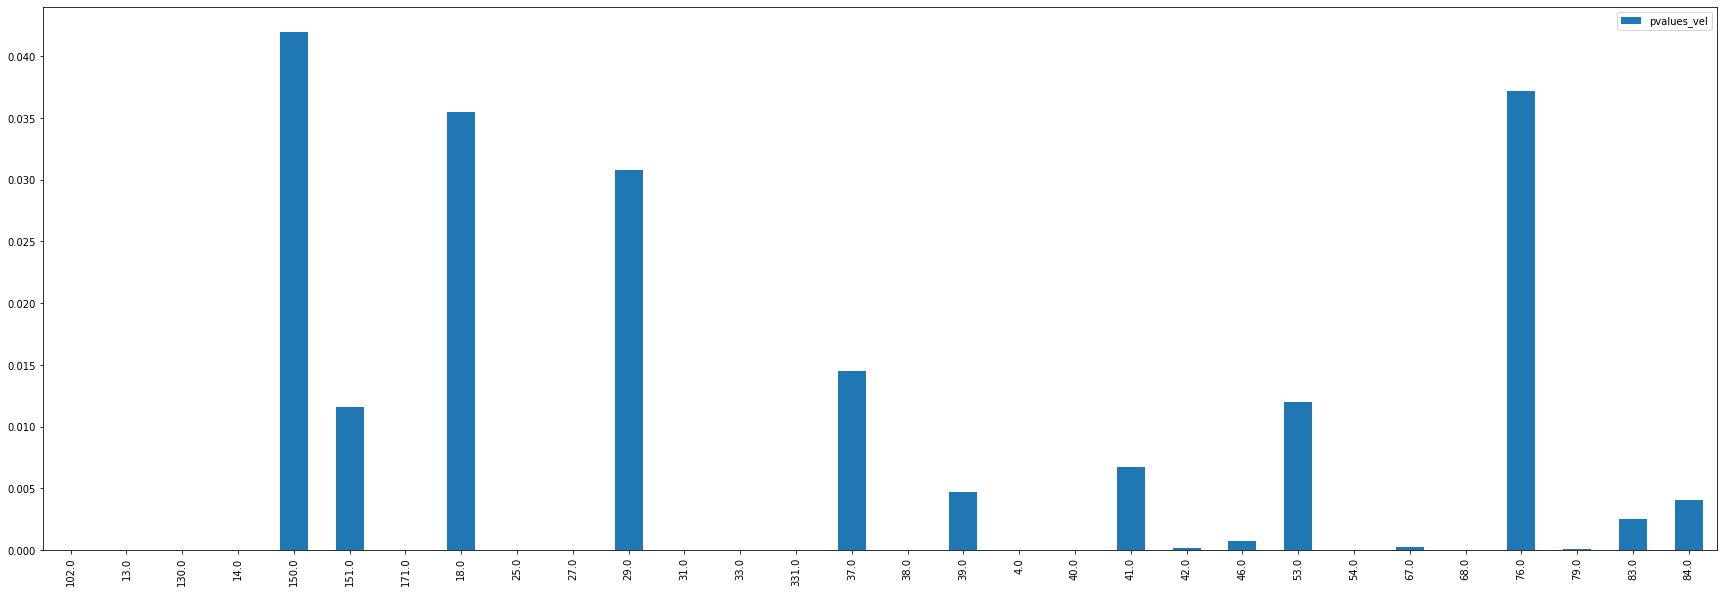

In [82]:
dfg[(dfg.pvalues_vel < 0.05)].plot(kind='bar', figsize=(30,10))

<AxesSubplot:>

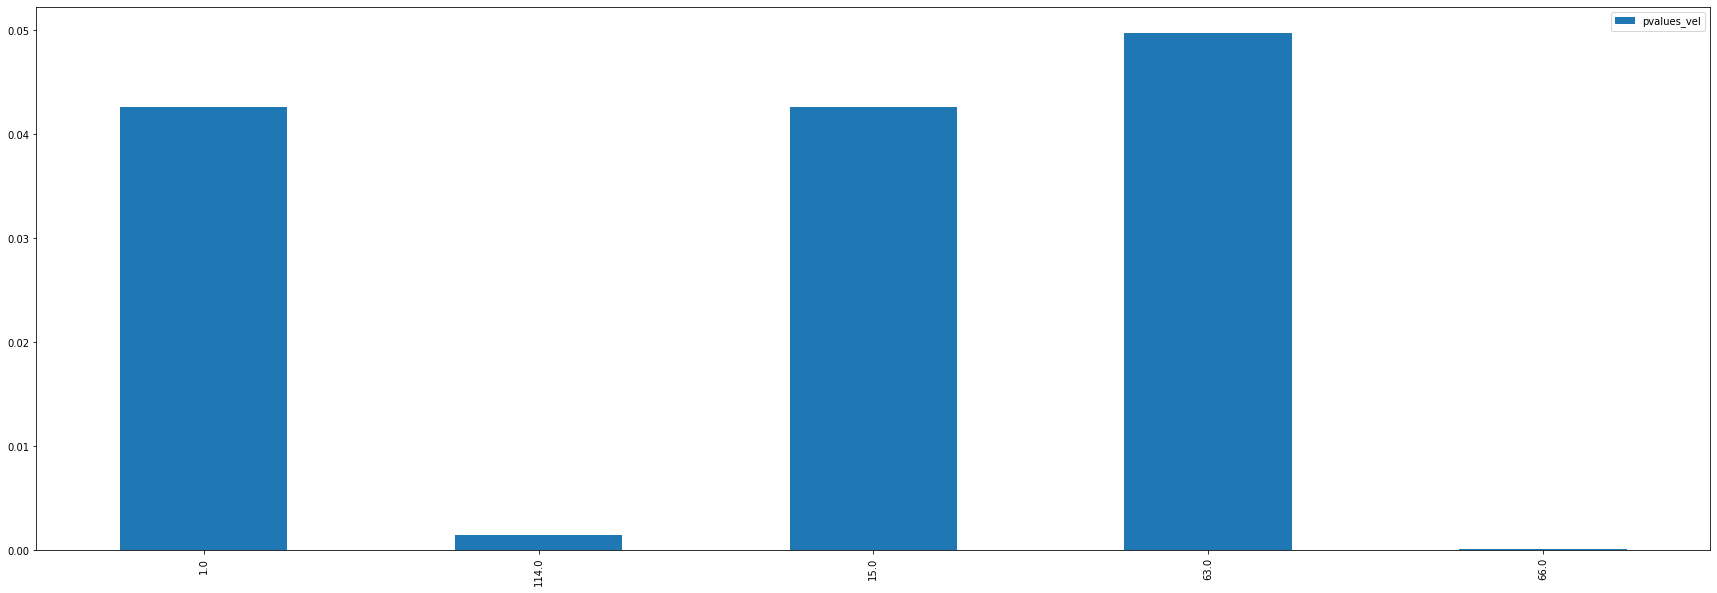

In [83]:
dfl[(dfl.pvalues_vel < 0.05)].plot(kind='bar', figsize=(30,10))

In [84]:
print( f'Rejeitamos a hipótese de que estas {len(dfg[(dfg.pvalues_vel < 0.05)])} linhas: \n\n{dfg[(dfg.pvalues_vel < 0.05)].index.values}')
print()
print('(H0) possuem a mediana de suas velocidades menores que a mediana de toda a amostra')
print()
print('Aceitamos a hipótese alternativa que estas linhas tem uma mediana superior à mediana da amostra')

Rejeitamos a hipótese de que estas 30 linhas: 

['102.0' '13.0' '130.0' '14.0' '150.0' '151.0' '171.0' '18.0' '25.0'
 '27.0' '29.0' '31.0' '33.0' '331.0' '37.0' '38.0' '39.0' '4.0' '40.0'
 '41.0' '42.0' '46.0' '53.0' '54.0' '67.0' '68.0' '76.0' '79.0' '83.0'
 '84.0']

(H0) possuem a mediana de suas velocidades menores que a mediana de toda a amostra

Aceitamos a hipótese alternativa que estas linhas tem uma mediana superior à mediana da amostra


In [85]:
print( f'Rejeitamos a hipótese de que estas {len(dfl[(dfl.pvalues_vel < 0.05)])} linhas: \n\n{dfl[(dfl.pvalues_vel < 0.05)].index.values}')
print()
print('(H0) possuem a mediana de suas velocidades maiores que a mediana de toda a amostra')
print()
print('Aceitamos a hipótese alternativa que estas linhas tem uma mediana inferior à mediana da amostra')

Rejeitamos a hipótese de que estas 5 linhas: 

['1.0' '114.0' '15.0' '63.0' '66.0']

(H0) possuem a mediana de suas velocidades maiores que a mediana de toda a amostra

Aceitamos a hipótese alternativa que estas linhas tem uma mediana inferior à mediana da amostra


## Plotar algumas trajetórias

### Funções auxíliares

In [86]:
def to_mercator(Coords):
    Coordinates =  Coords
    #literal_eval(Coords)        
    lat = Coordinates[1]
    lon = Coordinates[0]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale    
    
    return pd.Series((x, y))

def plot_fig(df_x, color):
    p = figure(x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(get_provider(tile_provider))
    #p.circle(
    p.line(
        x='lng_m',
        y='lat_m',
        color= color,
        source=df_x
    )
    try:
        p.circle(
            x='lng_m',
            y='lat_m',
            color= 'red',
            source=df_x[df_x.outlier == -1]
        )
    except:
        pass
    p.circle(
        x=df_x.iloc[0]['lng_m'],
        y=df_x.iloc[0]['lat_m'],
        color= 'blue',    
    )
    return (p)

def plot_map(data_line):
    p = figure(x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(get_provider(tile_provider))
    data_line[['lng_m','lat_m']] = data_line[['lng', 'lat']].apply(to_mercator, axis=1)
    p = plot_fig(data_line, 'black')
    show(p)

### A linha preta é a trajetória

### O ponto azul é a partida

### Os pontos vermelhos os outliers

#### Pontos Excluídos por ter menos que 50 pontos

In [87]:
plot_map(dfs_menos_q_50[0])
plot_map(dfs_menos_q_50[1])
plot_map(dfs_menos_q_50[10])

#### Algumas trajetórias válidas

In [88]:
plot_map(df[df.ID == 10])
plot_map(df[df.ID == 66])
plot_map(df[df.ID == 99])

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Alguns pontos que mesmo sendo detectados como válidos não aparentam ser quando plotados podem aparecer.

Observando a trajetória com maior distancia percorrida podemos ver se há algo equivocado. 
Podemos incrementar a exclusão de outliers retirando trajetórias muito curta ou muito longas basedas na distância total.

In [89]:
df1.dist_from_old_point.unique()

array([0.        , 1.98077615, 3.78394051, ..., 5.97356508, 1.66940787,
       1.13065551])

In [90]:
accum = df1.groupby(['line_id', 'ID' ]).dist_from_old_point.sum()
long_run = accum.max()

In [91]:
accum.reset_index()

,line_id,ID,dist_from_old_point
0,1.0,0,7096.993717
1,1.0,1,10467.496812
2,102.0,2,9255.685047
3,102.0,3,11588.653976
4,111.0,4,5739.710788
...,...,...,...
95,83.0,95,11785.548041
96,84.0,96,14884.509120
97,9.0,97,14866.669792
98,9.0,98,13486.643912


<AxesSubplot:>

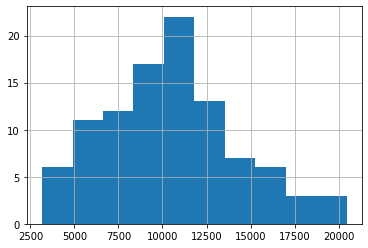

In [92]:
accum.hist()

<AxesSubplot:>

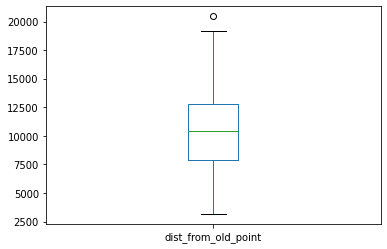

In [93]:
accum.plot(kind='box')

In [94]:
accum = accum.reset_index()
accum.columns = ['line', 'ID', 'total_dist']
accum.line = accum.line.astype('float')

/home/saci/hd/projetos/trajetorias/its_research/venvTraj/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


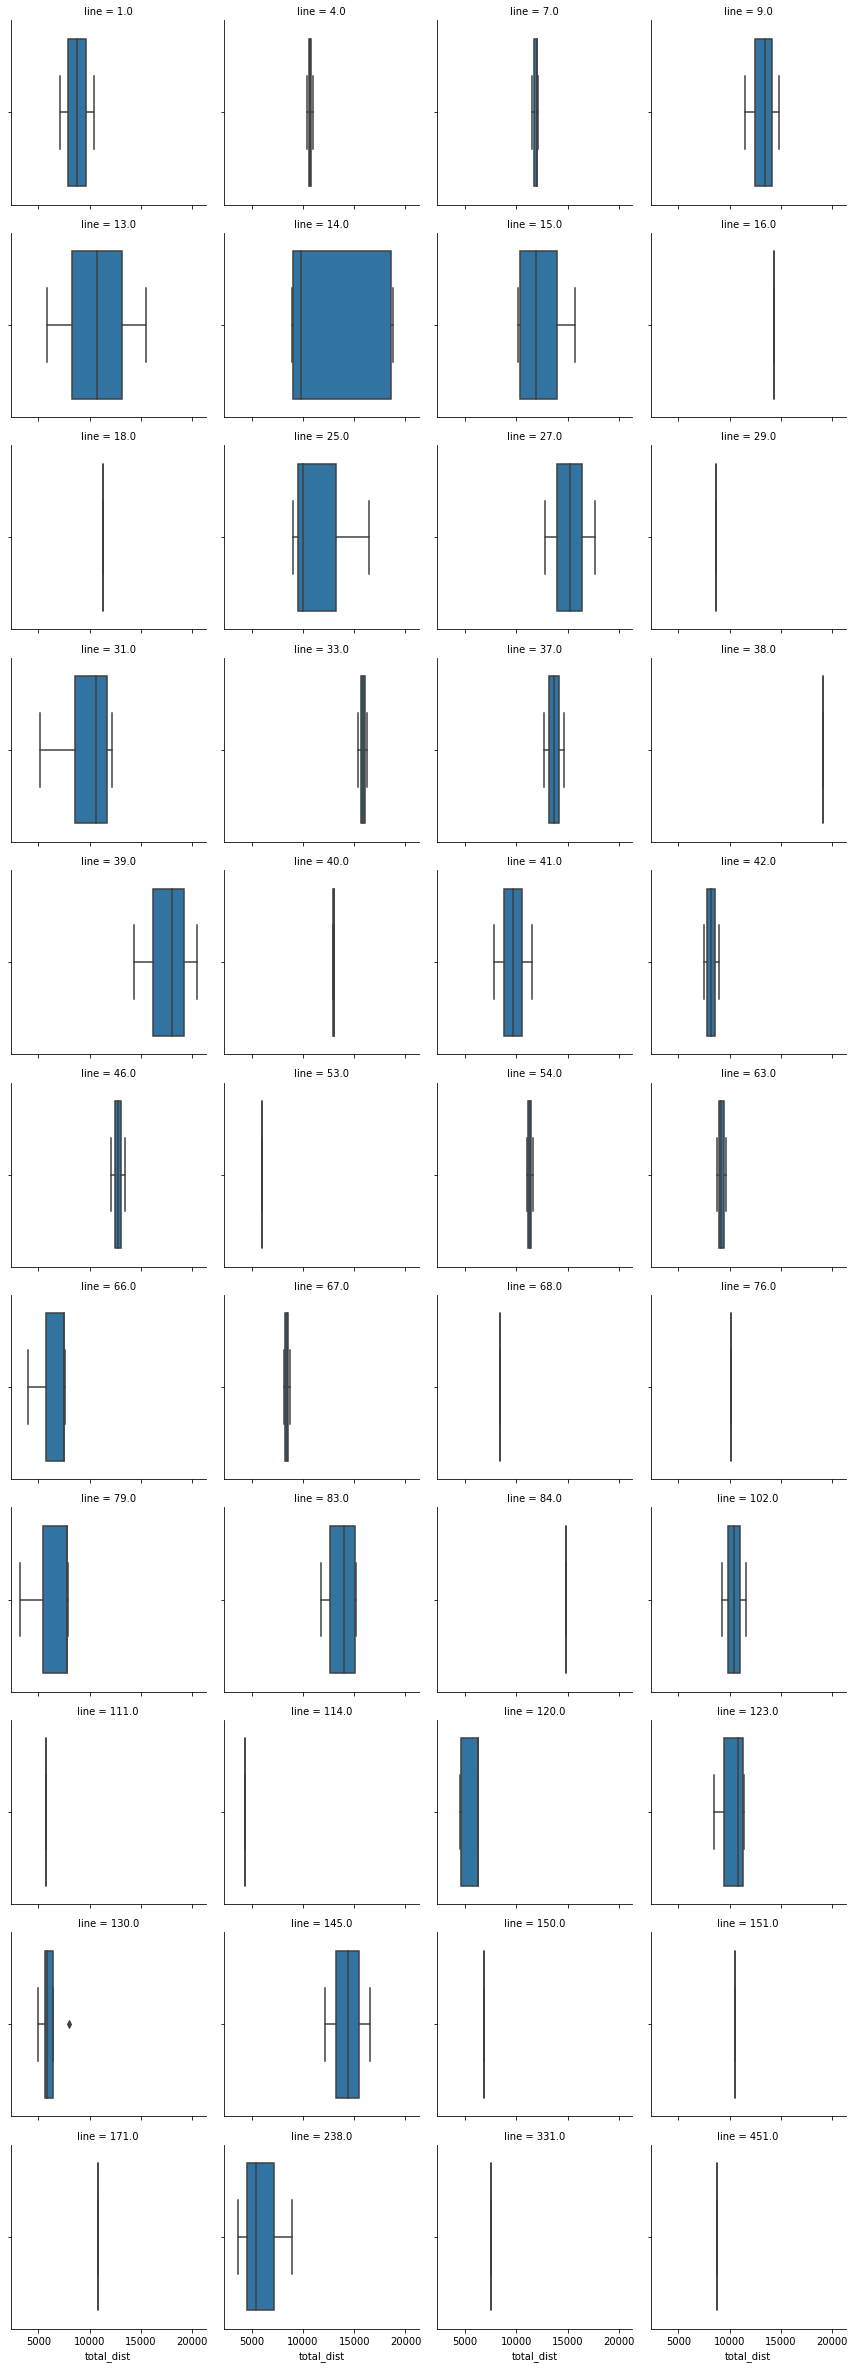

In [95]:
g = sns.FacetGrid(accum, col="line", col_wrap=4)
g.map(sns.boxplot, 'total_dist')
#sns.boxplot(data=accum, x='total_dist', hue='line')
#("alive", col = "deck", col_wrap = 3,data = df[df.deck.notnull()],kind = "count")
#sns.boxplot(x=var, y='SalePrice', data=housing, ax=subplot)

# Projeto 2

In [197]:
df.head()

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,datetime,hour,day,dist_from_old_point,time_from_old_point,velocity,acc,ID,outlier,outlier_norm,outlier_0,outlier2,outlier2_norm,MF_lat,MF_lng,MF_dist_from_old_point,MF_vel,MF_acc,outlier_MF
1452351,1357932478000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210967,53.324402,0,1001,43072,381.0,True,2013-01-11 19:27:58,19,11,0.000000,0,0.000000,0.000000,0,1,1,-1,1,1,53.382707,-6.355567,0.000000,0.000000,0.000000,1
1452840,1357932498000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324417,0,1001,43072,381.0,True,2013-01-11 19:28:18,19,11,1.980776,20,0.099039,0.004952,0,1,1,1,1,1,53.368211,-6.319193,2909.143428,145.457171,7.272859,-1
1453326,1357932519000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:39,19,11,3.783941,21,0.180188,0.008580,0,1,1,1,1,1,53.353707,-6.282820,2910.245061,138.583098,6.599195,-1
1453484,1357932523000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:43,19,11,0.000000,4,0.000000,0.000000,0,1,1,-1,1,1,53.339017,-6.246813,2902.306885,725.576721,181.394180,-1
1453894,1357932537000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210967,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:57,19,11,1.066127,14,0.076152,0.005439,0,1,1,1,-1,1,53.324394,-6.210977,2889.413357,206.386668,14.741905,-1


In [202]:
df.journey_id.unique()

<StringArray>
['00011001', '01021001', '01111001', '01140001', '01200001', '01201001',
 '01230001', '01231001', '00131007', '00131010', '01300001', '01301001',
 '00140001', '00141001', '00611001', '01450001', '01451001', '00151001',
 '015B1001', '015B1002', '01501001', '01511001', '00160001', '017A1004',
 '00181001', '02391001', '02701001', '025A0001', '025B1001', '025X1001',
 '077A1001', '029A1001', '00310003', '00320001', '031A1001', '00331001',
 '00331004', '033A0001', '00370001', '00381001', '039A0001', '039A1001',
 '00041001', '00400001', '00401001', '00411001', '041C0001', '00430001',
 '00431001', '045A0001', '046A1001', '00531001', '054A0001', '054A1001',
 '00630002', '00260001', '00661001', '00670001', '00690001', '00070001',
 '00071001', '00081001', '00761001', '00790001', '079A0001', '00830001',
 '00831001', '083A0001', '00841002', '00090001', '00091001']
Length: 71, dtype: string

In [203]:
dfx = df[df.journey_id.isin(['00011001', '01021001', '01111001', '01140001', '01200001', '01201001',
 '01230001',])]

In [204]:
dfx

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,datetime,hour,day,dist_from_old_point,time_from_old_point,velocity,acc,ID,outlier,outlier_norm,outlier_0,outlier2,outlier2_norm,MF_lat,MF_lng,MF_dist_from_old_point,MF_vel,MF_acc,outlier_MF
1452351,1357932478000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210967,53.324402,0,1001,43072,381.0,True,2013-01-11 19:27:58,19,11,0.000000,0,0.000000,0.000000,0,1,1,-1,1,1,53.382707,-6.355567,0.000000,0.000000,0.000000,1
1452840,1357932498000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324417,0,1001,43072,381.0,True,2013-01-11 19:28:18,19,11,1.980776,20,0.099039,0.004952,0,1,1,1,1,1,53.368211,-6.319193,2909.143428,145.457171,7.272859,-1
1453326,1357932519000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:39,19,11,3.783941,21,0.180188,0.008580,0,1,1,1,1,1,53.353707,-6.282820,2910.245061,138.583098,6.599195,-1
1453484,1357932523000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210983,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:43,19,11,0.000000,4,0.000000,0.000000,0,1,1,-1,1,1,53.339017,-6.246813,2902.306885,725.576721,181.394180,-1
1453894,1357932537000000,1.0,00011001,2013-01-11,4617,RD,False,-6.210967,53.324383,0,1001,43072,381.0,True,2013-01-11 19:28:57,19,11,1.066127,14,0.076152,0.005439,0,1,1,1,-1,1,53.324394,-6.210977,2889.413357,206.386668,14.741905,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146275,1357923386000000,123.0,01230001,2013-01-11,4423,SL,False,-6.227350,53.368584,-82,123014,38041,1490.0,True,2013-01-11 16:56:26,16,11,4.471933,20,0.223597,0.011180,15,1,1,1,1,1,53.368567,-6.227317,0.891959,0.044598,0.002230,1
1146691,1357923398000000,123.0,01230001,2013-01-11,4423,SL,False,-6.227350,53.368584,-22,123014,38041,1490.0,True,2013-01-11 16:56:38,16,11,0.000000,12,0.000000,0.000000,15,1,1,-1,1,1,53.368571,-6.227327,0.754925,0.062910,0.005243,1
1147117,1357923407000000,123.0,01230001,2013-01-11,4423,SL,False,-6.227334,53.368633,-22,123014,38041,1490.0,True,2013-01-11 16:56:47,16,11,5.556391,9,0.617377,0.068597,15,-1,-1,-1,-1,-1,53.368584,-6.227334,1.515963,0.168440,0.018716,1
1147784,1357923425000000,123.0,01230001,2013-01-11,4423,SL,False,-6.227334,53.368568,-22,123014,38041,1490.0,True,2013-01-11 16:57:05,16,11,7.234058,18,0.401892,0.022327,15,1,1,1,1,-1,53.368584,-6.227337,0.226318,0.012573,0.000699,1


In [205]:
X = dfx.loc[:, ['timestamp','lat','lng','hour', 'day', 'dist_from_old_point', 'time_from_old_point', 'velocity' ,'acc']].values
Y = dfx.journey_id.astype('category').cat.codes.values

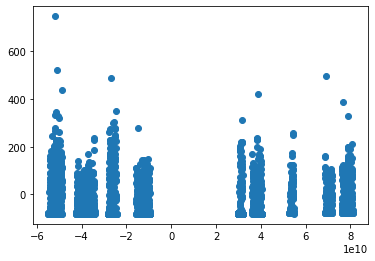

In [206]:
#label_name = iris.target_names

from sklearn.decomposition import PCA
data = PCA(n_components=2).fit_transform(X)

#color_label = {'setosa': 'blue', 'versicolor': 'red', 'virginica': 'magenta'}
#y_label = [label_name[x] for x in y]
#label_color = [color_label[x] for x in y_label]

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


plt.scatter(data[:,0], data[:, 1], )
#team_patches = [mpatches.Patch(color=color, label=team) for team, color in color_label.items()]
#plt.legend(handles=team_patches)
plt.show()

In [207]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0, n_init=20)
print(kmeans) # modelo

KMeans(n_clusters=7, n_init=20, random_state=0)


In [208]:
kmeans.fit(X) # ajustando o modelo
y_pred_kmeans = kmeans.labels_


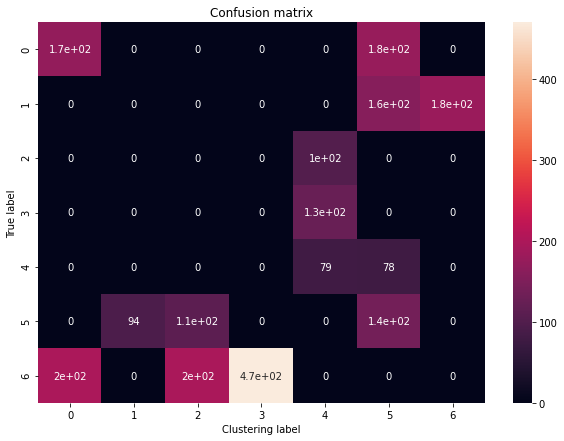

In [209]:
import sklearn.metrics
import seaborn as sns
confusion_matrix = sklearn.metrics.confusion_matrix(Y, y_pred_kmeans)

plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [171]:
sklearn.metrics.confusion_matrix?